# A simple keras implementation of CBRAIN

The creation of the data sets is done in the data_conversion notebook.

In [33]:
# Imports
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as nc
from collections import OrderedDict

In [14]:
# Some basic setup
np.random.seed(42)
sns.set_style('dark')
sns.set_palette('deep')
sns.set_context('talk')
plt.rcParams["figure.figsize"] = (10,7)

# Directory where netCDF files are stored
data_dir = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/sample/'   # 100,000 samples

In [48]:
# Features and targets from Pierre's submit script
# Make it a dictionary with 
# Get variable meaning from ??? Need to look that up at some point!
feature_vars = OrderedDict({
    'TAP': 2,             # Temperature [z, sample]
    'QAP': 2,             # Specific humidity [z, sample]
    'OMEGA': 2,           # [z, sample]
    'SHFLX': 1,           # [sample]
    'LHFLX': 1,           # [sample]
    'LAT': 1,             # Latitude [sample]
    'dTdt_adiabatic': 2,  # [z, sample]
    'dQdt_adiabatic': 2,  # [z, sample]
    'QRL': 2,             # Long wave heating rate [z, sample]
    'QRS': 2,             # Short wave heating rate [z, sample]
})
target_vars = OrderedDict({
    'SPDT': 2,            # SP temperature tendency [z, sample]
    'SPDQ': 2,            # SP humidity tendency [z, sample]
})

## Visualize task of the network

The goal of this section is to get an intuition of the task at hand. What are the inputs, what are the outputs? How does this depend on latitude?

In [4]:
# Load the training set
train_out = nc.Dataset(data_dir + 'SPCAM_outputs_train.nc')
train_out

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): z(21), t(80000)
    variables(dimensions): float64 LAT(t), float64 PS(t), float64 SHFLX(t), float64 LHFLX(t), float64 OMEGA(z,t), float64 QAP(z,t), float64 TAP(z,t), float64 QRL(z,t), float64 QRS(z,t), float64 UBSP(z,t), float64 VBSP(z,t), float64 SPQC(z,t), float64 SPQG(z,t), float64 SPQI(z,t), float64 SPQR(z,t), float64 SPMC(z,t), float64 SPMCDN(z,t), float64 SPMCUDN(z,t), float64 SPMCUP(z,t), float64 SPMCUUP(z,t), float64 TPHYSTND(z,t), float64 PHQ(z,t), float64 SPDT(z,t), float64 SPDQ(z,t), float64 SPDQC(z,t), float64 SPDQI(z,t), float64 dTdt_adiabatic(z,t), float64 dQdt_adiabatic(z,t), float64 GRAD_UQ_H(z,t)
    groups: 

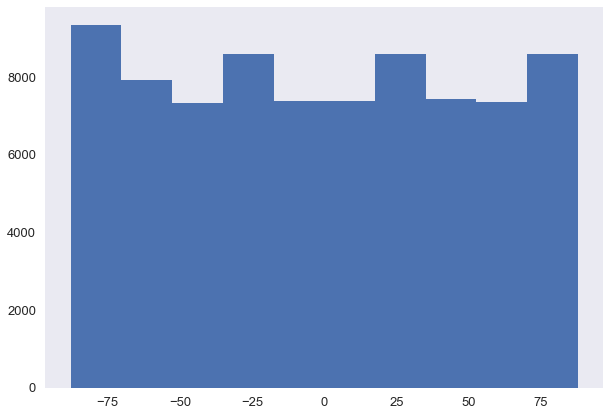

In [15]:
# Geographical distribution
plt.hist(train_out.variables['LAT']);

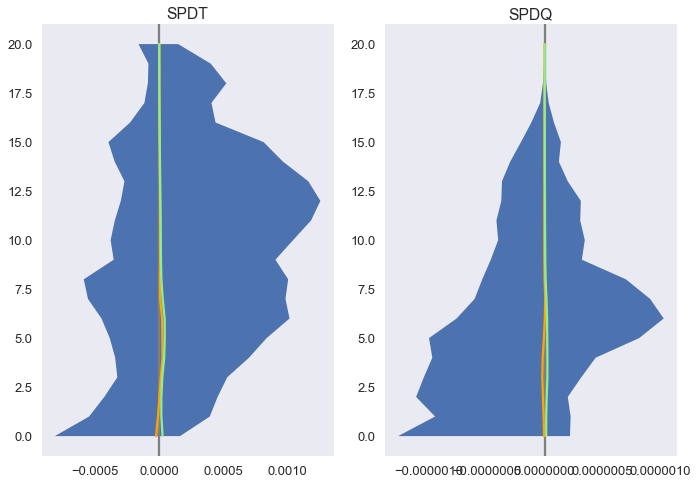

In [32]:
# Network output
z = np.arange(train_out.variables['SPDT'][:].shape[0]-1, -1, -1)
fig, axes = plt.subplots(1, 2)
for i, var in enumerate([train_out.variables['SPDT'], train_out.variables['SPDQ']]):
    mean = np.mean(var[:], axis=1)
    mean_abs = np.mean(np.abs(var[:]), axis=1)
    mn = np.min(var[:], axis=1); mx = np.max(var[:], axis=1)
    axes[i].set_title(var.name)
    axes[i].plot(mean, z, c='orange')
    axes[i].plot(mean_abs, z, c='lightgreen')
    axes[i].fill_betweenx(z, mn, mx, zorder=0.1)
    axes[i].axvline(0, c='gray', zorder=0.2)
plt.tight_layout()
plt.show()

In [57]:
def vis_in_out(outputs, sample_idx):
    fig, axes = plt.subplots(2, 5, figsize=(15, 10))
    in_axes = np.ravel(axes[:, :4])
    out_axes = np.ravel(axes[:, 4])
    
    in_2d = [k for k, v in feature_vars.items() if v == 2]
    in_1d = [k for k, v in feature_vars.items() if v == 1]
    for i, var_name in enumerate(in_2d):
        in_axes[i].plot(outputs.variables[var_name][:, sample_idx], z)
        in_axes[i].set_title(var_name)
    in_bars = [outputs.variables[v][sample_idx] for v in in_1d]
    in_axes[-1].bar(range(len(in_bars)), in_bars, tick_label=in_1d)
    
    for i, var_name in enumerate(target_vars.keys()):
        out_axes[i].plot(outputs.variables[var_name][:, sample_idx], z, c='r')
        out_axes[i].set_title(var_name)
    
    plt.suptitle('Sample %i' % sample_idx, fontsize=15)
    plt.tight_layout(rect=(0, 0, 1, 0.95))
    plt.show()

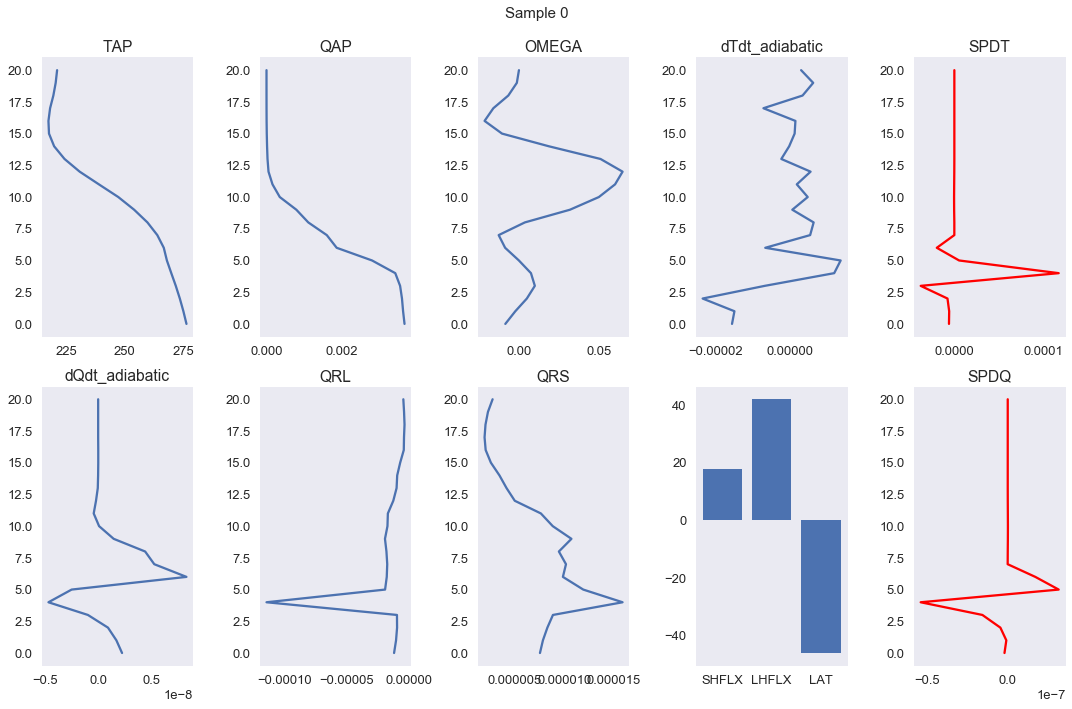

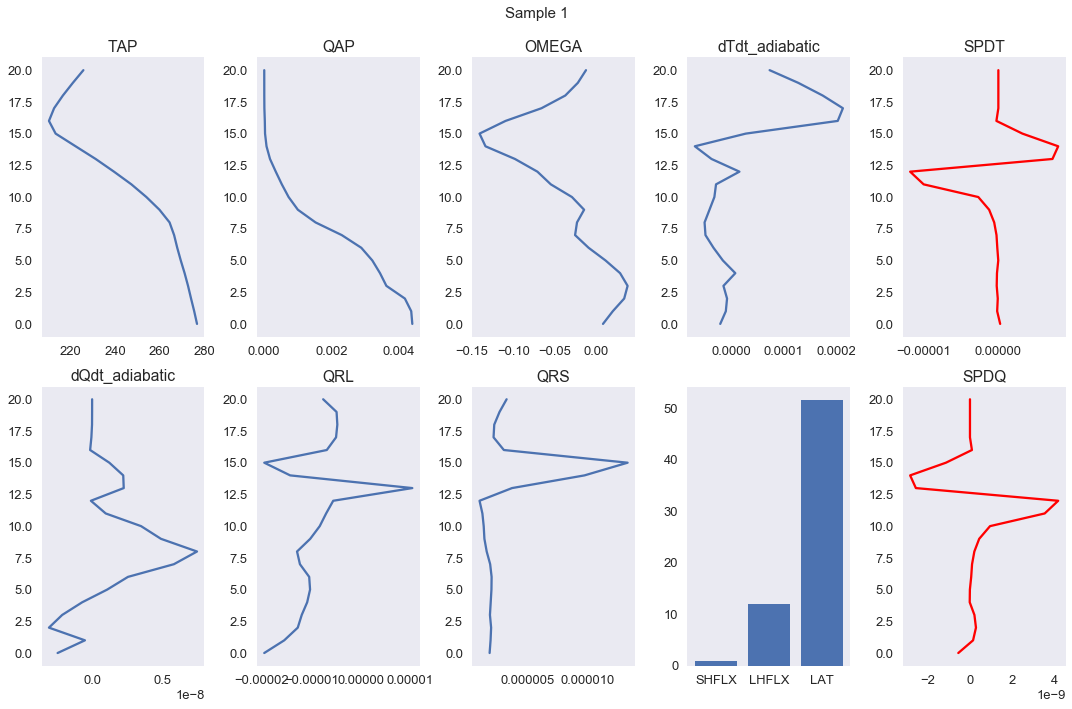

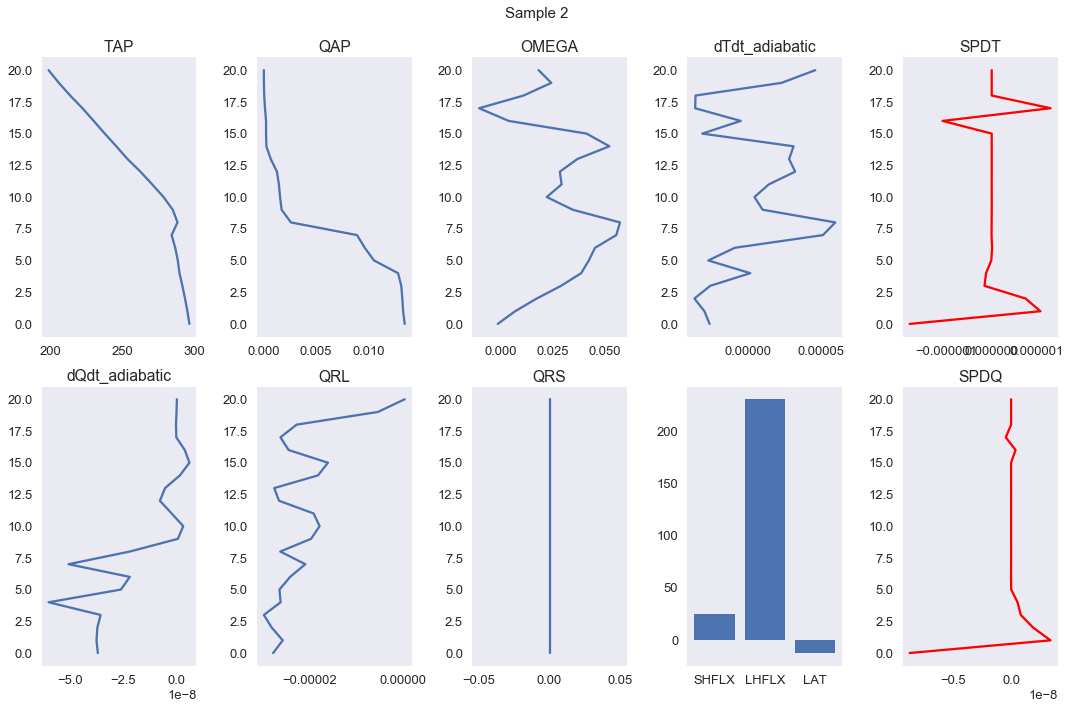

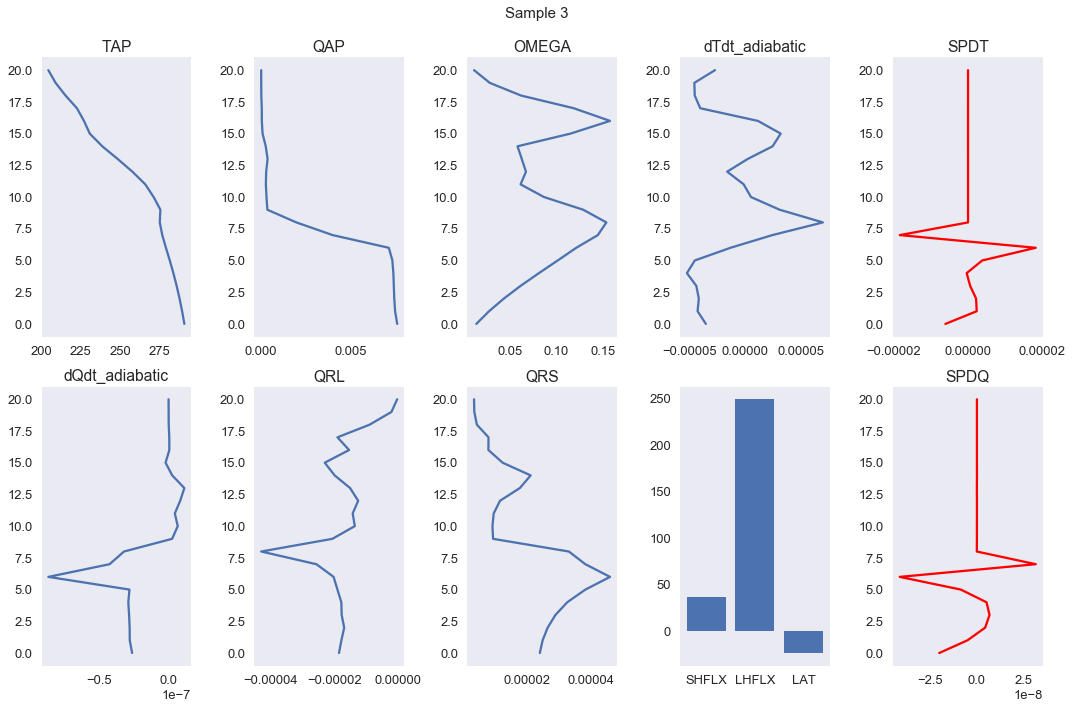

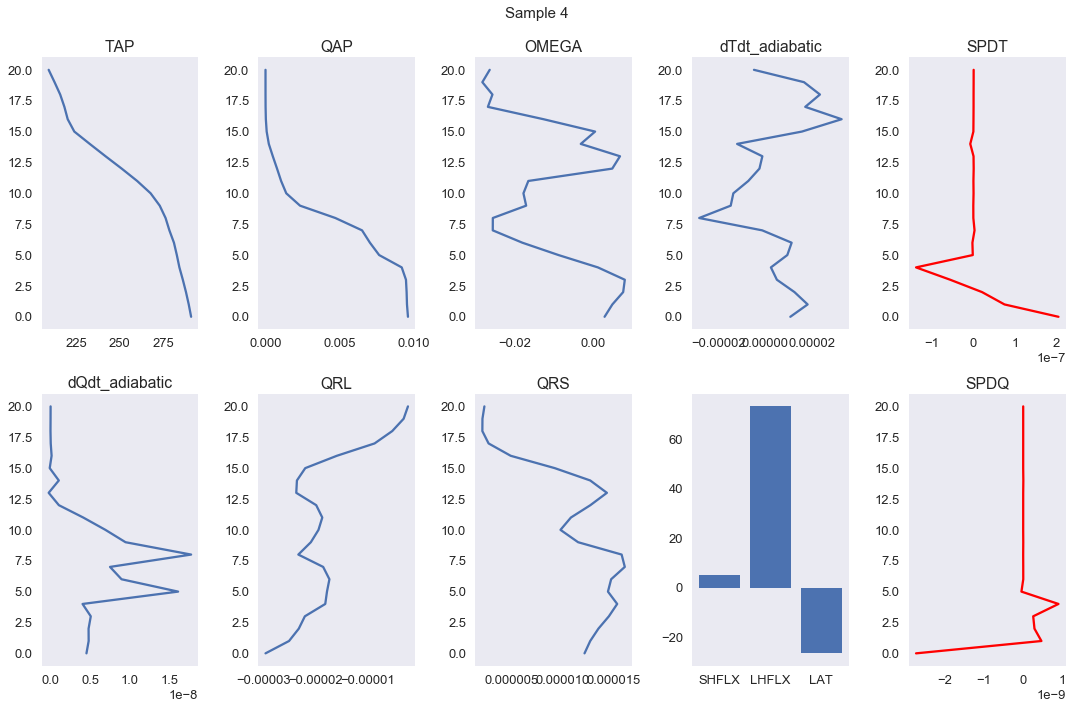

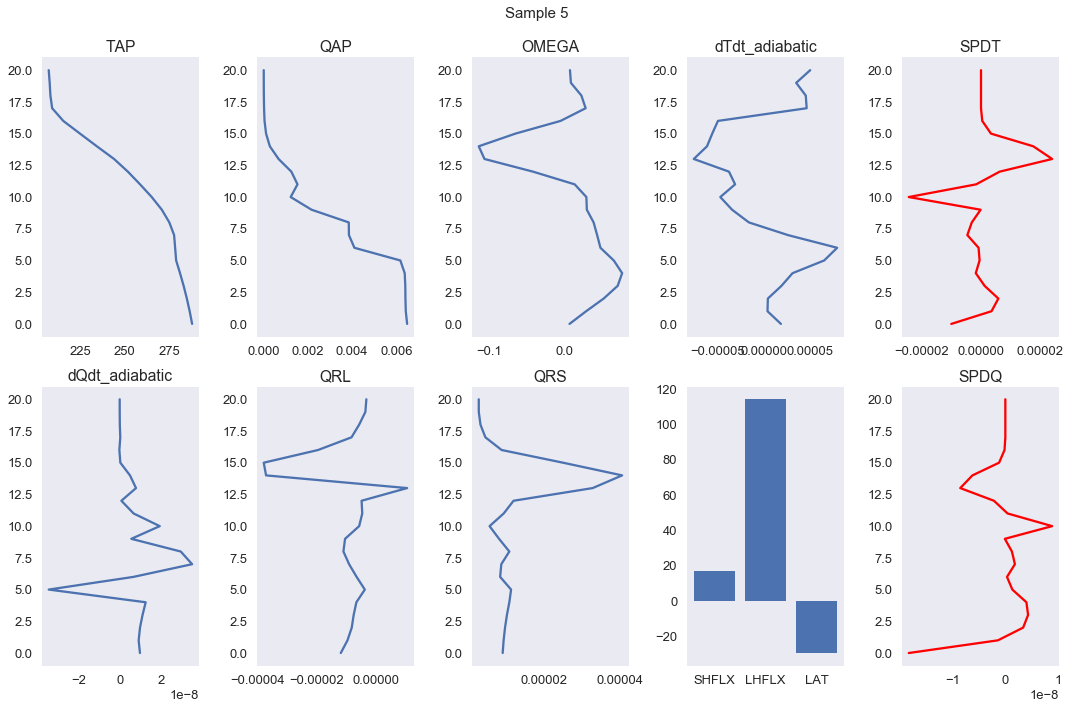

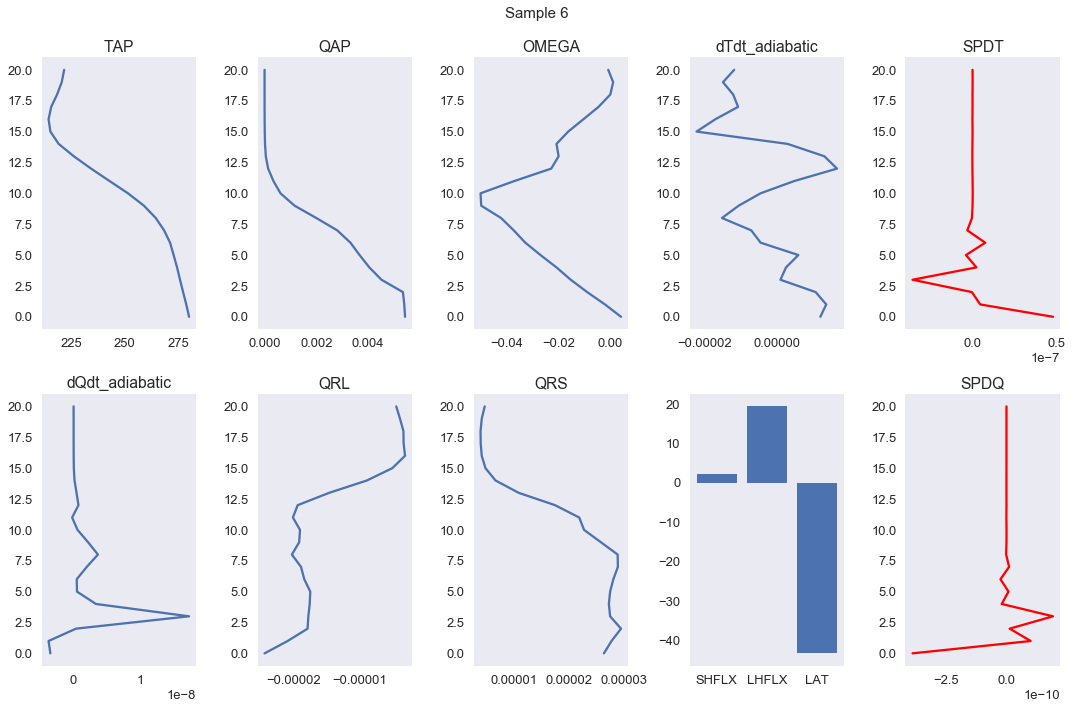

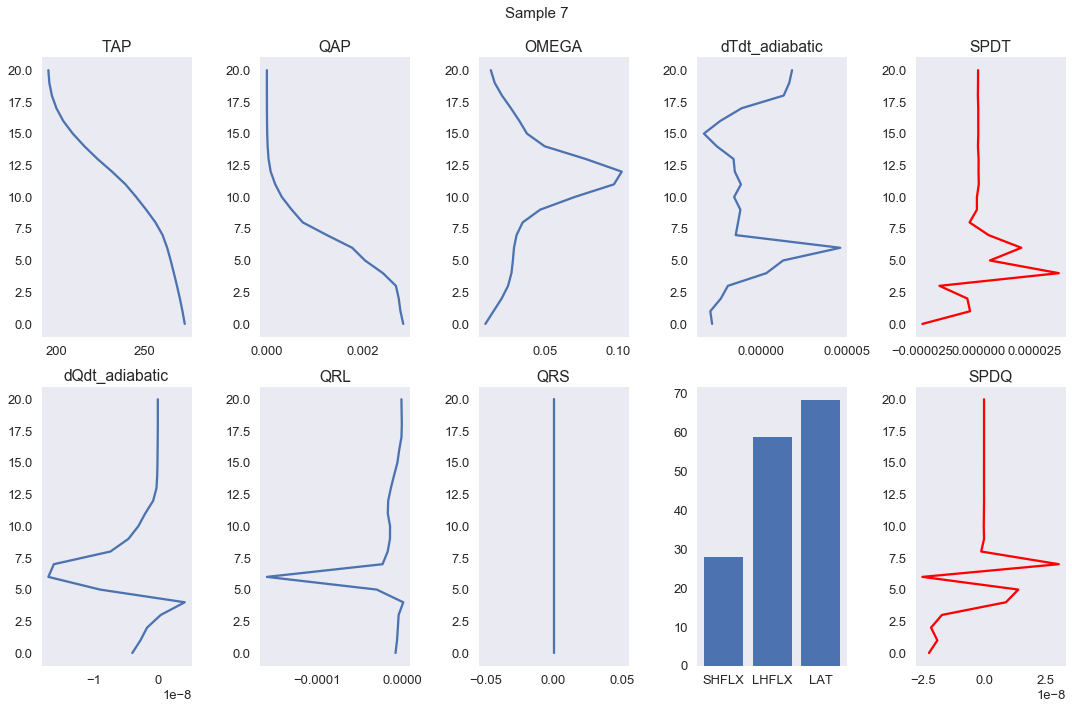

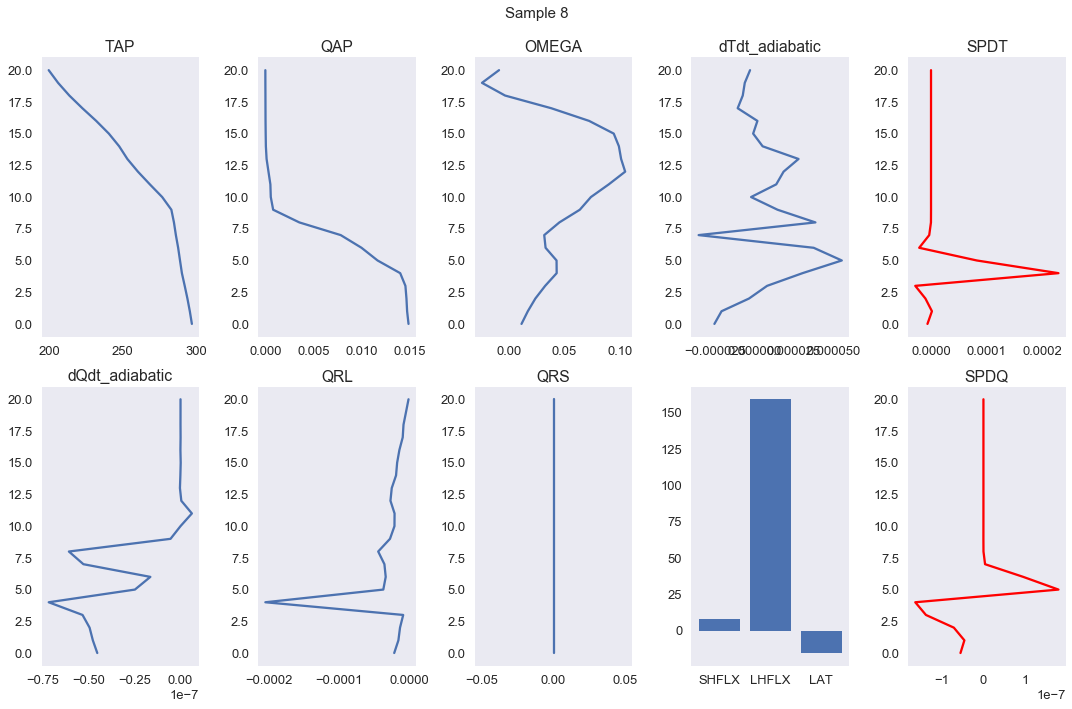

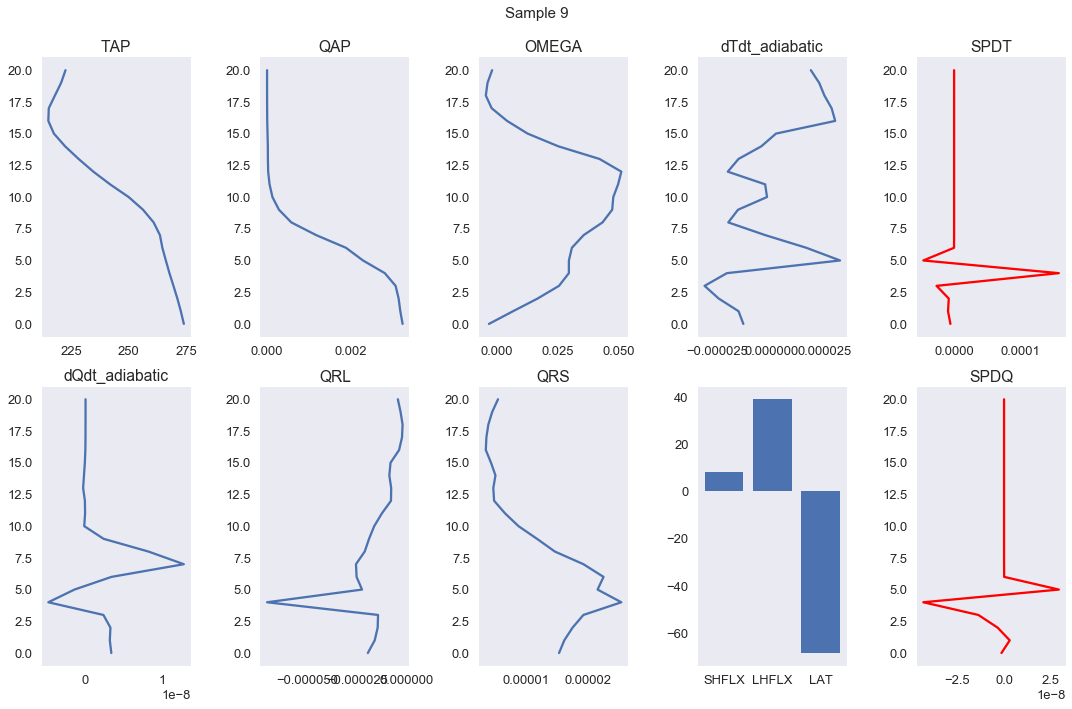

In [60]:
# We can just take the first 10 since I randomly shuffled the training and validation sets
for i in range(10):
    vis_in_out(train_out, i)

## Create a very simple network with sample data

Let's first create a simple network using the sample data as a reference for future developments. This dataset is small enough to fit in the RAM, so we don't have to load the data in batches.

In [65]:
# Load validation file
valid_out = nc.Dataset(data_dir + 'SPCAM_outputs_valid.nc')

In [61]:
# Load mean and std files
nc_mean = nc.Dataset(data_dir + 'SPCAM_mean.nc')
nc_std = nc.Dataset(data_dir + 'SPCAM_std.nc')

In [66]:
train_feature_list = []
valid_feature_list = []
for var_name in feature_vars.keys():
    train_var = np.atleast_2d(train_out.variables[var_name][:])
    train_var = np.rollaxis(train_var, 1, 0)
    train_var = (train_var - nc_mean.variables[var_name][:]) / nc_std.variables[var_name][:]
    valid_var = np.atleast_2d(valid_out.variables[var_name][:])
    valid_var = np.rollaxis(valid_var, 1, 0)
    valid_var = (valid_var - nc_mean.variables[var_name][:]) / nc_std.variables[var_name][:]
    train_feature_list.append(np.atleast_2d(train_var))
    valid_feature_list.append(np.atleast_2d(valid_var))

In [74]:
train_features = np.concatenate(train_feature_list, axis=1)
valid_features = np.concatenate(valid_feature_list, axis=1)

In [75]:
train_features.shape

(80000, 150)

In [76]:
# Unit conversion from dataLoad
train_targets = np.concatenate([
    train_out.variables['SPDT'][:] * 1000.,
    train_out.variables['SPDQ'][:] * 2.5e6,
], axis=0)
valid_targets = np.concatenate([
    valid_out.variables['SPDT'][:] * 1000.,
    valid_out.variables['SPDQ'][:] * 2.5e6,
], axis=0)
train_targets.shape

(42, 80000)

In [81]:
train_targets = np.rollaxis(train_targets, 1, 0)
valid_targets = np.rollaxis(valid_targets, 1, 0)

In [83]:
train_targets.shape

(80000, 42)

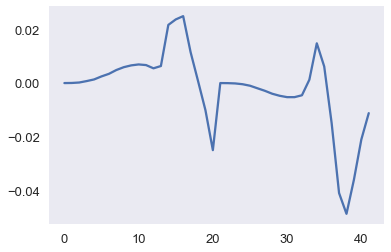

In [84]:
plt.plot(np.mean(train_targets, axis=0))
plt.show()

In [96]:
train_out.close()
valid_out.close()
nc_mean.close()
nc_std.close()

## Create network

In [85]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

Using TensorFlow backend.


In [86]:
model = Sequential([
    Dense(100, input_shape=(train_features.shape[1],)),
    Dense(100),
    Dense(train_targets.shape[1], activation='linear')
])

In [95]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               15100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 42)                4242      
Total params: 29,442
Trainable params: 29,442
Non-trainable params: 0
_________________________________________________________________


In [87]:
model.compile(Adam(0.001), loss='mse')

In [92]:
model.fit(train_features, train_targets, batch_size=1024, epochs=10,
          validation_data=(valid_features, valid_targets))

Train on 80000 samples, validate on 20000 samples
Epoch 1/10
80000/80000 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0034
Epoch 2/10
80000/80000 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0034
Epoch 3/10
80000/80000 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0033
Epoch 4/10
80000/80000 [==============================] - 0s - loss: 0.0030 - val_loss: 0.0034
Epoch 5/10
80000/80000 [==============================] - 0s - loss: 0.0030 - val_loss: 0.0033
Epoch 6/10
80000/80000 [==============================] - 0s - loss: 0.0030 - val_loss: 0.0033
Epoch 7/10
80000/80000 [==============================] - 0s - loss: 0.0030 - val_loss: 0.0033
Epoch 8/10
80000/80000 [==============================] - 0s - loss: 0.0030 - val_loss: 0.0034
Epoch 9/10
80000/80000 [==============================] - 0s - loss: 0.0030 - val_loss: 0.0033
Epoch 10/10
80000/80000 [==============================] - 0s - loss: 0.0030 - val_loss: 0.0033

In [93]:
preds = model.predict(train_features)

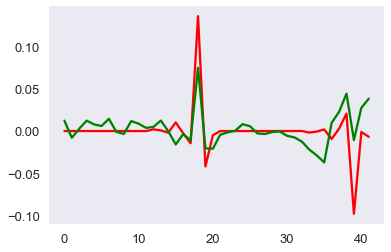

In [94]:
plt.plot(train_targets[11], c='r')
plt.plot(preds[11], c='g')
plt.show()

## Write a data generator function

In [97]:
import h5py

In [98]:
fh = h5py.File(data_dir + 'SPCAM_mean.nc')

In [163]:
a = fh['TAP']

In [164]:
a.ndim

1

https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.html

In [319]:
class DataGenerator(object):
    """Generate batches
    """
    def __init__(self, data_dir, out_name, batch_size, feature_names, 
                 target_names=['SPDT', 'SPDQ'], shuffle=True):
        """Initialize generator
        """
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.feature_names = feature_names
        assert target_names == ['SPDT', 'SPDQ'], 'No other targets implemented.'
        self.target_names = target_names
        
        # Open files
        self.out_file = h5py.File(data_dir + out_name)
        self.mean_file = h5py.File(data_dir + 'SPCAM_mean.nc')
        self.std_file = h5py.File(data_dir + 'SPCAM_std.nc')
        
        # Determine sizes
        self.n_samples = self.out_file['TAP'].shape[1]
        self.n_batches = int(self.n_samples / batch_size)
        
        # Create ID list
        idxs = np.arange(0, self.n_samples, self.batch_size)
        if self.shuffle:
            np.random.shuffle(idxs)
        self.idxs = idxs
        
    def generate(self):
        """Generate data batches
        """
        while True:
            for i in range(self.n_batches):
                batch_idx = self.idxs[i]
                x = self.__get_features(batch_idx)
                y = self.__get_targets(batch_idx)
                yield x, y
            
    def __get_features(self, batch_idx):
        """Load and scale the features
        """
        # Load features
        f_list = []
        for v in self.feature_names:
            # NOTE to self: This below is much (factor 5) faster than 
            # self.out_file[v].value[:,...] 
            if self.out_file[v].ndim == 2:
                f = self.out_file[v][:, batch_idx:batch_idx+self.batch_size].T
            elif self.out_file[v].ndim == 1:
                f = np.atleast_2d(self.out_file[v][batch_idx:batch_idx+self.batch_size]).T
            else:
                raise ValueError('Wrong feature dimensions.')
            # normalize
            f = (f - self.mean_file[v].value) / self.std_file[v].value
            f_list.append(f)
        return np.concatenate(f_list, axis=1)
        
    def __get_targets(self, batch_idx):
        """Load and convert the targets
        """
        targets = np.concatenate([
            self.out_file['SPDT'][:, batch_idx:batch_idx+self.batch_size] * 1000.,
            self.out_file['SPDQ'][:, batch_idx:batch_idx+self.batch_size] * 2.5e6,
        ], axis=0)
        return targets.T


In [284]:
train_batches = DataGenerator(data_dir, 'SPCAM_outputs_train.nc', 1024, feature_vars.keys(), 
                              shuffle=True)

Idxs: [      0    1024    2048 ..., 3693568 3694592 3695616]


In [217]:
valid_batches = DataGenerator(data_dir, 'SPCAM_outputs_valid.nc', 1024, feature_vars.keys(), 
                              shuffle=True)

In [218]:
model = Sequential([
    Dense(100, input_shape=(train_features.shape[1],)),
    Dense(100),
    Dense(train_targets.shape[1], activation='linear')
])

In [219]:
model.compile(Adam(0.001), loss='mse')

In [221]:
model.fit_generator(train_batches.generate(), train_batches.n_batches, epochs=10,
                    validation_data=valid_batches.generate(), 
                    validation_steps=valid_batches.n_batches)

Epoch 1/10
78/78 [==============================] - 4s - loss: 0.0203 - val_loss: 0.0131
Epoch 2/10
78/78 [==============================] - 4s - loss: 0.0101 - val_loss: 0.0082
Epoch 3/10
78/78 [==============================] - 3s - loss: 0.0069 - val_loss: 0.0062
Epoch 4/10
78/78 [==============================] - 4s - loss: 0.0054 - val_loss: 0.0052
Epoch 5/10
78/78 [==============================] - 4s - loss: 0.0047 - val_loss: 0.0046ss: 0.0 - ETA: 0s - loss: 0.0
Epoch 6/10
78/78 [==============================] - 4s - loss: 0.0042 - val_loss: 0.0043
Epoch 7/10
78/78 [==============================] - 4s - loss: 0.0039 - val_loss: 0.0040ss: 0.0 - ETA: 0s - l
Epoch 8/10
78/78 [==============================] - 3s - loss: 0.0037 - val_loss: 0.0039
Epoch 9/10
78/78 [==============================] - 3s - loss: 0.0036 - val_loss: 0.0037
Epoch 10/10
78/78 [==============================] - 4s - loss: 0.0034 - val_loss: 0.0037


So this works, but is quite a bit slower than the full implementation. I tried multiprocessing, but that doesn't work... 

## Try full dataset!

In [224]:
data_dir = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/' 

In [329]:
train_batches = DataGenerator(data_dir, 'SPCAM_outputs_train.nc', 1024, feature_vars.keys(), 
                              shuffle=True)

In [330]:
valid_batches = DataGenerator(data_dir, 'SPCAM_outputs_valid.nc', 10000, feature_vars.keys(), 
                              shuffle=True)

In [306]:
train_batches.n_samples, train_batches.n_batches

(3696230, 3609)

In [326]:
model = Sequential([
    Dense(100, input_shape=(train_features.shape[1],)),
    Dense(100),
    Dense(train_targets.shape[1], activation='linear')
])

In [327]:
model.compile(Adam(0.001), loss='mse')

In [ ]:
model.fit_generator(train_batches.generate(), train_batches.n_batches, epochs=10,
                    validation_data=valid_batches.generate(), 
                    validation_steps=valid_batches.n_batches)

Epoch 1/10
3609/3609 [==============================] - 59s - loss: 0.0044 - val_loss: 0.0026
Epoch 2/10
3609/3609 [==============================] - 59s - loss: 0.0030 - val_loss: 0.0024
Epoch 3/10
3609/3609 [==============================] - 59s - loss: 0.0025 - val_loss: 0.0023
Epoch 4/10
3609/3609 [==============================] - 58s - loss: 0.0023 - val_loss: 0.0023
Epoch 5/10
2830/3609 [======================>.......] - ETA: 12s - loss: 0.0022